# 作业说明

✓代码跑通

请大家根据课上所学内容，在 MyDNN类中补全代码，构造CNN网络，保证程序跑通。

✓调优

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！

# **任务描述：**

### 本次实践是一个多分类任务，需要将照片中的宝石分别进行识别，完成**宝石的识别**

### **实践平台：百度AI实训平台-AI Studio、PaddlePaddle2.0.0 动态图**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


# 深度神经网络(DNN)

### **深度神经网络（Deep Neural Networks，简称DNN）是深度学习的基础，其结构为input、hidden（可有多层）、output，每层均为全连接。**
![](https://ai-studio-static-online.cdn.bcebos.com/c60fc28848cf469fa3a7824aa637a03f3b2b213ce7b84659919cb24b4430bffb)



# 数据集介绍

* **数据集文件名为archive_train.zip,archive_test.zip。**

* **该数据集包含25个类别不同宝石的图像。**

* **这些类别已经分为训练和测试数据。**

* **图像大小不一，格式为.jpeg。**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data89755


In [19]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset

# 1、数据准备

In [20]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data89755/utf-8''archive_train.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",        #要解压的路径 
    "train_list_path": "./train.txt",              #train_data.txt路径
    "eval_list_path": "./eval.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 100,                                    #训练轮数
    "train_batch_size": 8,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.01                                     #超参数学习率
    } 
}



In [21]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''

    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")


In [22]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    class_dirs.sort()
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 15 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [23]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

文件已解压
{'input_size': [3, 224, 224], 'class_dim': 25, 'src_path': "data/data89755/utf-8''archive_train.zip", 'target_path': '/home/aistudio/data/dataset', 'train_list_path': './train.txt', 'eval_list_path': './eval.txt', 'label_dict': {'0': 'Alexandrite', '1': 'Almandine', '2': 'Benitoite', '3': 'Beryl Golden', '4': 'Carnelian', '5': 'Cats Eye', '6': 'Danburite', '7': 'Diamond', '8': 'Emerald', '9': 'Fluorite', '10': 'Garnet Red', '11': 'Hessonite', '12': 'Iolite', '13': 'Jade', '14': 'Kunzite', '15': 'Labradorite', '16': 'Malachite', '17': 'Onyx Black', '18': 'Pearl', '19': 'Quartz Beer', '20': 'Rhodochrosite', '21': 'Sapphire Blue', '22': 'Tanzanite', '23': 'Variscite', '24': 'Zircon'}, 'readme_path': '/home/aistudio/data/readme.json', 'num_epochs': 100, 'train_batch_size': 8, 'learning_strategy': {'lr': 0.01}}
生成数据列表完成！


In [24]:
class Reader(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [25]:
train_dataset = Reader('/home/aistudio/',mode='train')

eval_dataset = Reader('/home/aistudio/',mode='eval')

#训练数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True,drop_last=True)
#测试数据加载
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [26]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/dataset/Cats Eye/cats eye_33.jpg 	标签值 5
742
文件名 /home/aistudio/data/dataset/Rhodochrosite/rhodochrosite_6.jpg 	标签值 20
69
(3, 224, 224)
(1,)


In [27]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

# 2、定义模型

In [28]:

#定义DNN网络
class MyDNN(paddle.nn.Layer):
    def __init__(self):
        super(MyDNN,self).__init__()

        self.linear1 = paddle.nn.Linear(in_features=3*224*224,out_features=1824)
        self.relu1   = paddle.nn.ReLU()

        self.linear2 = paddle.nn.Linear(in_features=1824,out_features=512)
        self.relu2   = paddle.nn.ReLU()

        self.linear3 = paddle.nn.Linear(in_features=512,out_features=128)
        self.relu3   = paddle.nn.ReLU()

        self.linear4 = paddle.nn.Linear(in_features=128,out_features=25)

    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑

        # input.shage(16,3,224,224)
        x = paddle.reshape(input, shape=[-1, 3 * 224 * 224])
        x = self.linear1(x)
        x = self.relu1(x)

        x = self.linear2(x)
        x = self.relu2(x)

        x = self.linear3(x)
        x = self.relu3(x)

        y = self.linear4(x)
        return y

In [29]:

#定义CNN网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()

        self.hidden1 = paddle.nn.Conv2D(in_channels=3,out_channels=64,kernel_size=3,stride=1)
        

        self.hidden2 = paddle.nn.Conv2D(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        
        self.hidden3 = paddle.nn.MaxPool2D(kernel_size=4,stride=4)
        

        self.hidden4 = paddle.nn.Linear(128*55*55,25)  ###################################################请填入正确的输出通道数和图片大小

    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑

        # input.shage(16,3,224,224)
        x = self.hidden1(input)

        x = self.hidden2(x)
    
        x = self.hidden3(x)

        x = paddle.reshape(x, shape=[-1,128*55*55])  ###################################################请填入正确的输出通道数和图片大小

        out = self.hidden4(x)
        return out

# 3、训练模型

train_pass:0,batch_id:5,train_loss:[3.2096014],train_acc:[0.0625]
train_pass:0,batch_id:10,train_loss:[3.195132],train_acc:[0.0625]
train_pass:0,batch_id:15,train_loss:[3.0365148],train_acc:[0.125]
train_pass:0,batch_id:20,train_loss:[3.027556],train_acc:[0.1875]
train_pass:0,batch_id:25,train_loss:[2.8507411],train_acc:[0.375]
train_pass:0,batch_id:30,train_loss:[3.2180727],train_acc:[0.125]
train_pass:0,batch_id:35,train_loss:[2.8846424],train_acc:[0.25]
train_pass:0,batch_id:40,train_loss:[2.9415371],train_acc:[0.1875]
train_pass:0,batch_id:45,train_loss:[2.8741803],train_acc:[0.125]
train_pass:1,batch_id:5,train_loss:[2.9134016],train_acc:[0.1875]
train_pass:1,batch_id:10,train_loss:[2.7048254],train_acc:[0.375]
train_pass:1,batch_id:15,train_loss:[2.909473],train_acc:[0.1875]
train_pass:1,batch_id:20,train_loss:[2.5687299],train_acc:[0.1875]
train_pass:1,batch_id:25,train_loss:[2.9707751],train_acc:[0.125]
train_pass:1,batch_id:30,train_loss:[2.2342281],train_acc:[0.4375]
train_pa

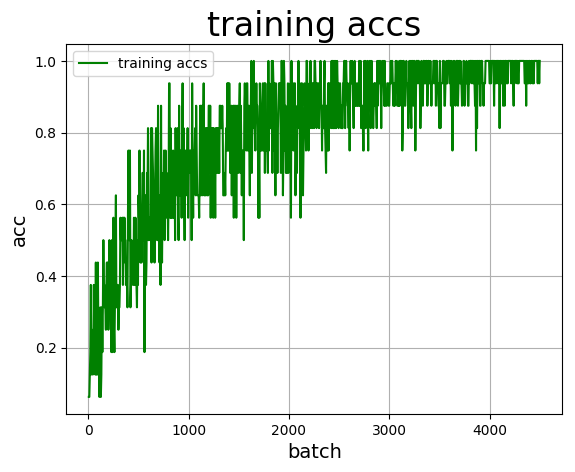

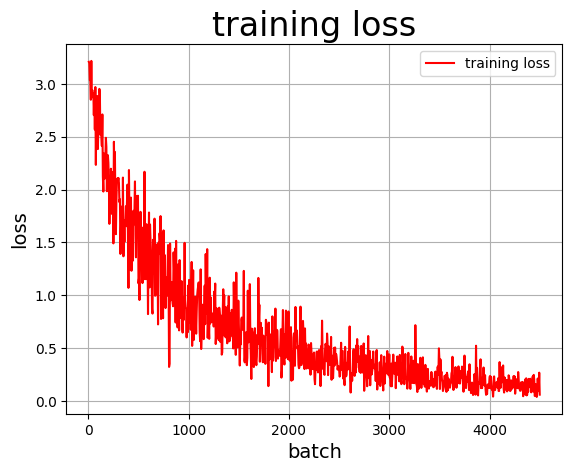

In [30]:

import time
model=MyDNN() #模型实例化
model.train() #训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

epochs_num=train_parameters['num_epochs'] #迭代次数



for pass_num in range(train_parameters['num_epochs']):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]

        predict=model(image) #数据传入model

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))
        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度


paddle.save(model.state_dict(),'MyDNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)



train_pass:0,batch_id:5,train_loss:[23.155832],train_acc:[0.]
train_pass:0,batch_id:10,train_loss:[5.784436],train_acc:[0.0625]
train_pass:0,batch_id:15,train_loss:[42.61947],train_acc:[0.0625]
train_pass:0,batch_id:20,train_loss:[15.28358],train_acc:[0.1875]
train_pass:0,batch_id:25,train_loss:[2.161129],train_acc:[0.375]
train_pass:0,batch_id:30,train_loss:[1.982806],train_acc:[0.5]
train_pass:0,batch_id:35,train_loss:[2.104506],train_acc:[0.4375]
train_pass:0,batch_id:40,train_loss:[2.2327566],train_acc:[0.25]
train_pass:0,batch_id:45,train_loss:[5.007907],train_acc:[0.3125]
train_pass:1,batch_id:5,train_loss:[1.4278914],train_acc:[0.5]
train_pass:1,batch_id:10,train_loss:[1.0233762],train_acc:[0.8125]
train_pass:1,batch_id:15,train_loss:[0.9632479],train_acc:[0.625]
train_pass:1,batch_id:20,train_loss:[1.4654762],train_acc:[0.5625]
train_pass:1,batch_id:25,train_loss:[1.160762],train_acc:[0.75]
train_pass:1,batch_id:30,train_loss:[0.90501],train_acc:[0.75]
train_pass:1,batch_id:35,

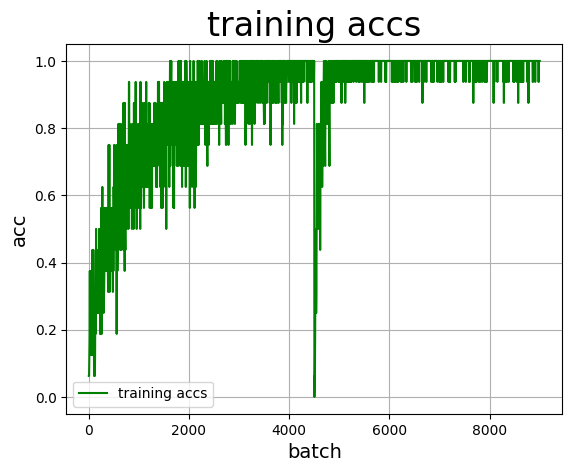

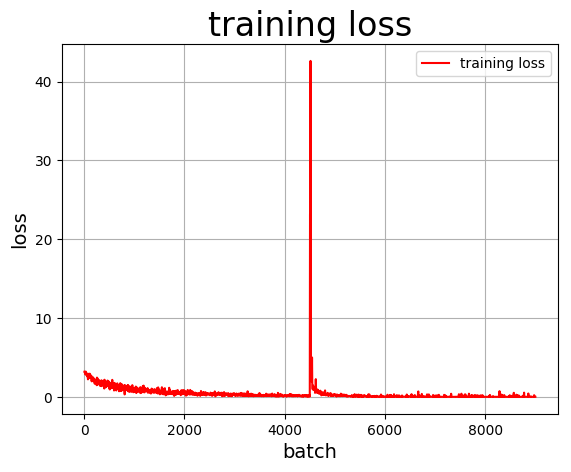

In [32]:

import time
model=MyCNN() #模型实例化
model.train() #训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

epochs_num=train_parameters['num_epochs'] #迭代次数


for pass_num in range(train_parameters['num_epochs']):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]

        predict=model(image) #数据传入model

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))
        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度


paddle.save(model.state_dict(),'MyCNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)


# 4、模型评估

### **DNN评估结果**

In [31]:
#模型评估
para_state_dict = paddle.load("MyDNN")
model = MyDNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)       
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:",avg_acc)

当前模型在验证集上的准确率为: 0.7361111


### **CNN评估结果**

In [33]:
#模型评估
para_state_dict = paddle.load("MyCNN")
model = MyCNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)       
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:",avg_acc)

当前模型在验证集上的准确率为: 0.7138889


# 5、模型预测

In [34]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = "/home/aistudio/data/data89755/utf-8''archive_test.zip"
infer_dst_path = '/home/aistudio/data/archive_test'
unzip_infer_data(infer_src_path,infer_dst_path)

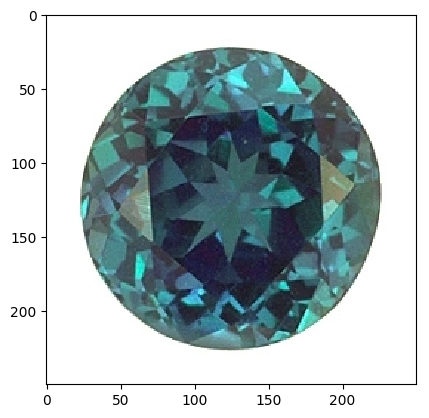

1
第1个样本,被预测为：Alexandrite,真实标签为：alexandrite
结束


In [36]:
'''
模型预测
'''
para_state_dict = paddle.load("MyDNN")
model = MyDNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

#展示预测图片
infer_path='data/archive_test/alexandrite_18.jpg'
img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

#对预测图片进行预处理
infer_imgs = []
infer_imgs.append(load_image(infer_path))
infer_imgs = np.array(infer_imgs)

label_dic = train_parameters['label_dict']

print(len(infer_imgs))


for i in range(len(infer_imgs)):
    data = infer_imgs[i]
    dy_x_data = np.array(data).astype('float32')
    dy_x_data=dy_x_data[np.newaxis,:, : ,:]
    img = paddle.to_tensor (dy_x_data)
    out = model(img)
    lab = np.argmax(out.numpy())  #argmax():返回最大数的索引

    print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split("_")[0]))

print("结束")


# DNN和CNN的对比结果

1. 在训练次数比较小的情况下，这里我选用的epoch为10，也就是训练了十次，最终结果，DNN识别验证集准确率为：0.5-0.7，而CNN的准确率却能达到0.7-0.8，**所以，在训练次数较小的情况下，宝石识别CNN的效率要优于DNN**
2. 在训练次数比较大的情况下，这里我选用的epoch为100，最终结果，DNN准确率与CNN的准确率都能达到0.7-0.8
# 综上，在图像识别这方面，CNN的效率要比DNN的效率高。